In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from TSForecasting.mage_calc import MageDataSet

In [6]:
#Extract Data
data = pd.read_csv("~/Desktop/NCSA_genomics/Python - notebooks/TSForecasting/Data/Hall/data_hall_raw.csv")
data = data[data['subjectId']=='1636-69-032']

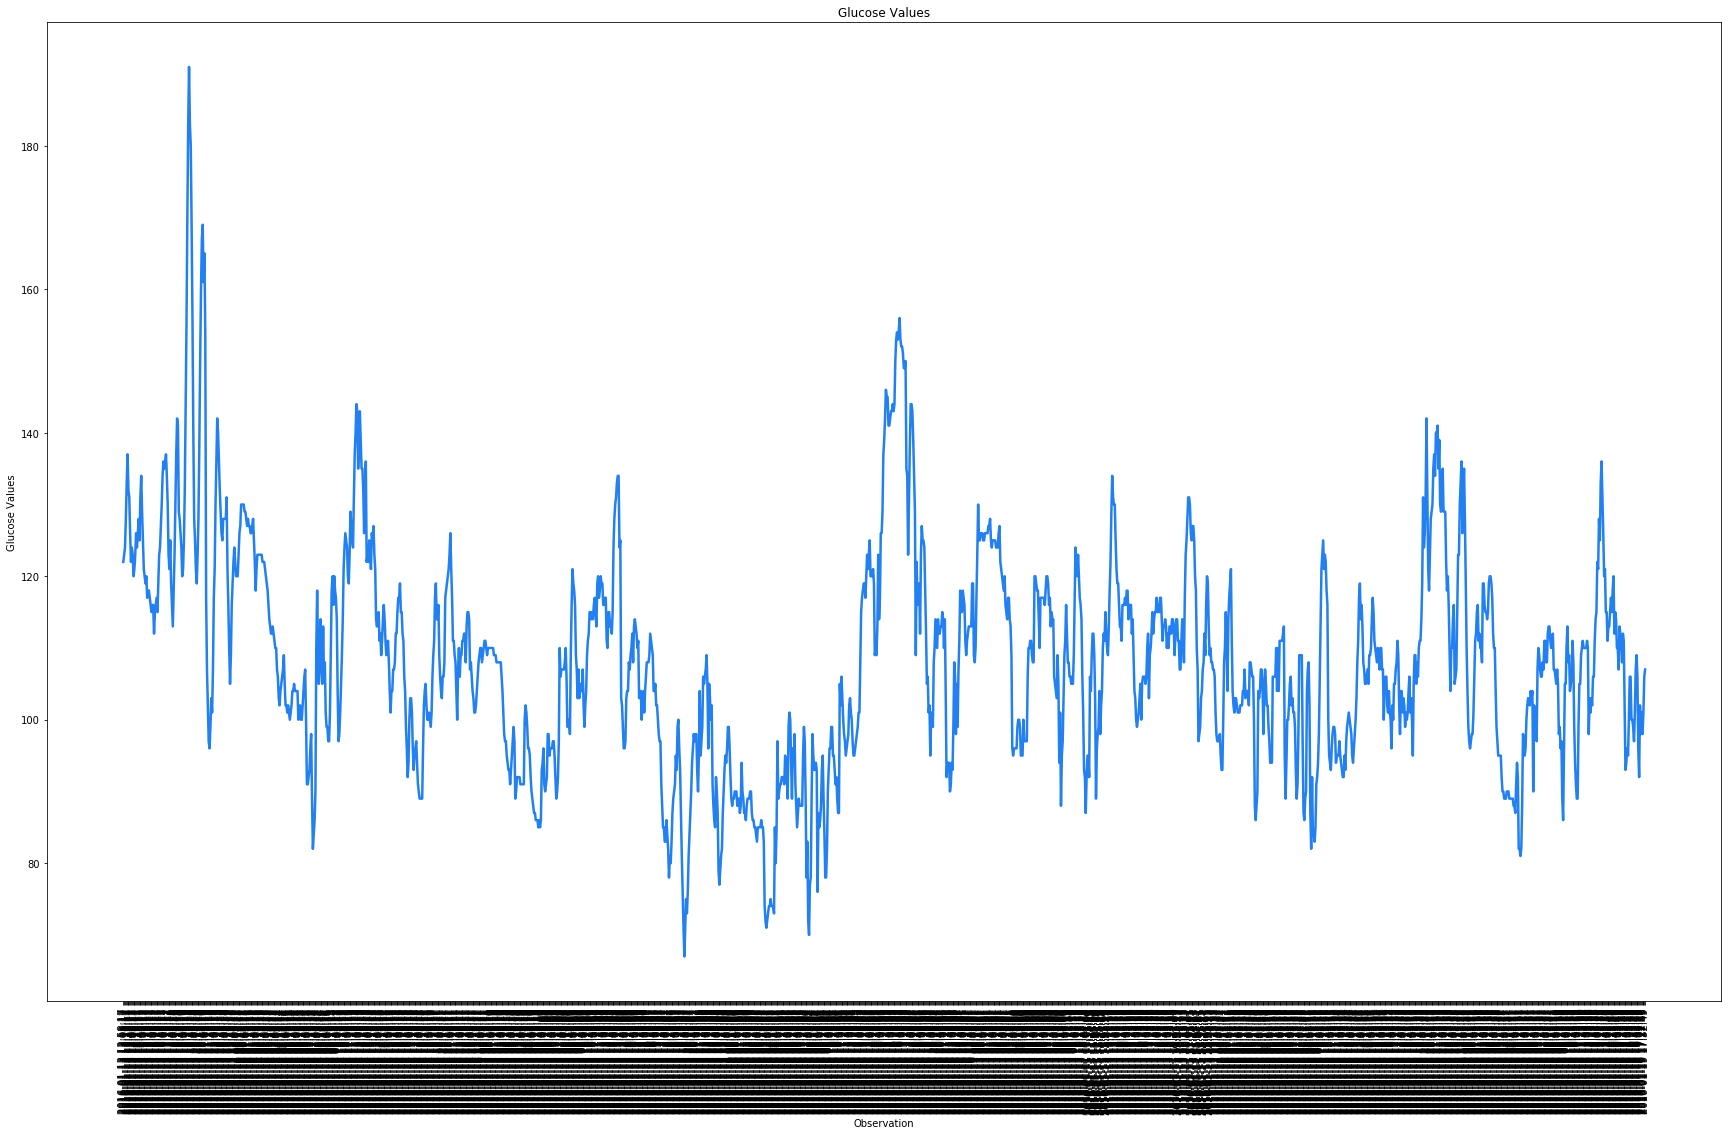

In [14]:
plt.figure(figsize=(30, 18))
plt.plot(data['Display Time'],data['GlucoseValue'], label='True', color='#2280f2', linewidth=2.5)
plt.title("Glucose Values")
plt.xlabel('Observation')
plt.ylabel('Glucose Values')
plt.xticks(rotation=90)
plt.show()

In [8]:

glucs = data['GlucoseValue'].to_list()
indices = [1*i for i in range(len(glucs))]
m = MageDataSet(indices, glucs)
k = m.getMAGE()

print(k)
    


29.62264150943396
